In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh, eigs
from qutip import Qobj, ptrace
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
        (1, 6), (1, 7), (1, 8), (1, 9), (2, 6),
        (2, 9), (2, 10), (2, 11), (3, 7), (3, 8),
        (3, 10), (3, 11), (4, 8), (4, 9), (4, 10),
        (4, 11), (5, 6), (5, 7), (5, 10), (5, 11),
        (6, 7), (6, 9), (7, 8), (8, 9), (10, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^z * sigma_j^z for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^z * sigma_j^z for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def entanglement_entropy(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = total_size - subsystem_size
    
    # Reshape psi into a 2^subsystem_size x 2^environment_size matrix
    psi_matrix = psi.reshape((2**subsystem_size, 2**environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

In [3]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,1,2]  # Indices of qubits to keep
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
eigenvalues, eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-38.60482369]
Corresponding eigenvector shape: (4096, 1)
Density matrix shape: (4096, 4096)
qobj density matrix shape: (4096, 4096)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: 2.3985993496445192e-05


In [5]:
#  Lowest 100 eigenvalues of H

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='BE')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6, 7]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

100%|██████████| 100/100 [03:45<00:00,  2.26s/it]

Minimum eigenvalues of the traced-out density matrix: [-3.43476178e-17 -1.91370391e-17 -1.39284803e-17 -1.03278727e-17
 -3.85591289e-18 -2.53793631e-19  5.59487953e-19  3.18825848e-18
  6.37624755e-18  1.11854421e-17  1.14602142e-17  4.39152513e-09
  9.30895153e-09  2.38434001e-08  6.07788730e-08  6.17726378e-08
  7.49226285e-08  1.02226639e-07  1.12854469e-07  1.20294710e-07
  2.03879842e-07  3.06799377e-07  3.35400882e-07  3.92689668e-07
  4.29198843e-07  4.47298152e-07  4.51771381e-07  5.00066458e-07
  5.75002084e-07  6.92730566e-07  8.40802111e-07  1.65418939e-06
  1.85208072e-06  2.07871851e-06  2.11382096e-06  2.13060767e-06
  2.38979278e-06  2.47441759e-06  2.66256659e-06  2.76120087e-06
  2.97919118e-06  3.06629456e-06  3.09210168e-06  3.24591337e-06
  3.52038136e-06  3.58785408e-06  4.16078996e-06  4.27412278e-06
  4.28710765e-06  4.65481620e-06  4.81598051e-06  4.84804115e-06
  4.85196390e-06  5.05690462e-06  5.11103315e-06  5.38048118e-06
  6.44708145e-06  6.66955033e-06  6.

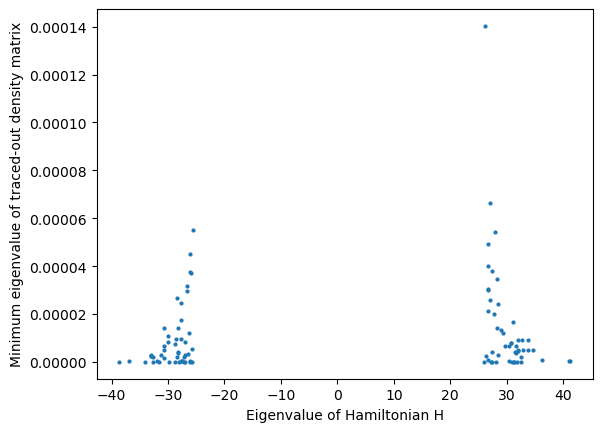

In [6]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [7]:
# All eigenvalues of H

# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6, 7]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced), 
    min_eigenvalues.append(min_eigenvalue)

100%|██████████| 4096/4096 [2:39:28<00:00,  2.34s/it]  


In [8]:
print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

Minimum eigenvalues of the traced-out density matrix: [[1.20294710e-07]
 [5.75002084e-07]
 [2.38434001e-08]
 ...
 [8.40802111e-07]
 [3.06799377e-07]
 [4.47298152e-07]]


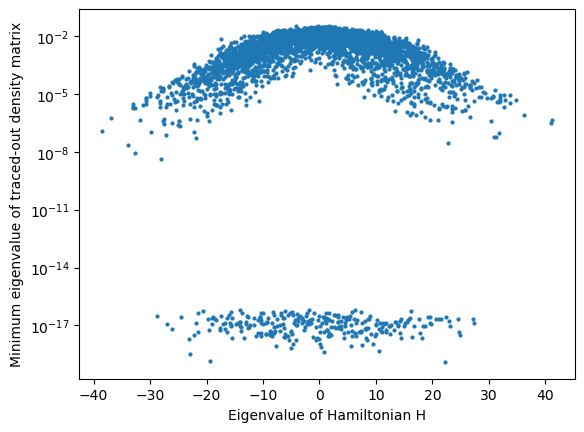

In [14]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [10]:
# ENTANGLEMENT ENTROPY COMPUTATION

# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

print(len(entropies))

4096


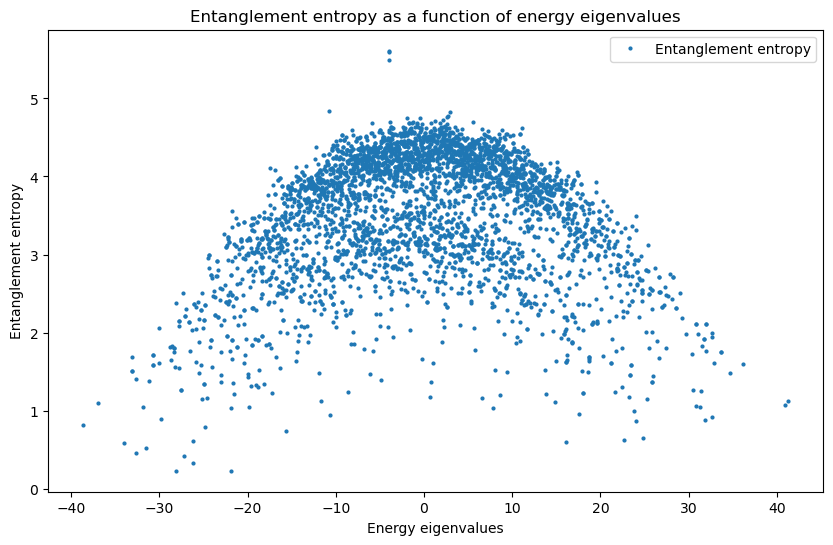

In [13]:
# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, entropies, 'o', label='Entanglement entropy', markersize=2)
plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

In [ ]:
#print rdm for 4 adjacent spins for the mid states corresponding to non full rank. make it correspond with the poinmts in entanglement entropy plot. 
#look at zero entries of the rdm. find a 4 spins charge commuting with the rdm.